## We will create a recurrent neural network to generate new names based on the lord of the rings.

# Data Analysis and Preprocessing

In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/lord-of-the-rings-character-data/Characters.csv")
df = df.drop(columns="Url")
# Some examples from the data
df.head()

,Name,Race
0,Adanel,Human
1,Adrahil I,Human
2,Adrahil II,Human
3,Aegnor,Elf
4,Aerin,Human


In [2]:
# Sum the number of names per race
df_summary = df.groupby(by="Race").count()
df_summary

,Name
Race,
Dwarf,47
Elf,97
Hobbit,215
Human,387
Maiar,11


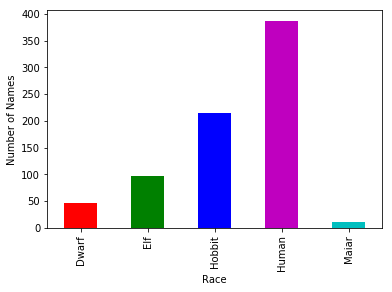

In [3]:
# Visualization
ax = df_summary.unstack()["Name"].plot(kind="bar", color=['r', 'g', 'b', 'm', 'c'], legend=False)
ax.set_ylabel("Number of Names");

### Our network will take in a single letter and predict what the next letter should be.

### We will represent the letters with one-hot vectors, for which we need to know how many types of characters we can use.

In [4]:
# Collect all unique characters in the data
letters = list({letter for name in df["Name"] for letter in name})
letters

[':',
 'x',
 't',
 's',
 'V',
 "'",
 'M',
 'n',
 'z',
 'q',
 'F',
 'É',
 'R',
 'L',
 'l',
 'k',
 'P',
 'h',
 'J',
 'O',
 'd',
 'D',
 'ú',
 'y',
 '(',
 'a',
 'e',
 'i',
 'u',
 'v',
 'á',
 'ó',
 'û',
 'A',
 'N',
 'T',
 'ô',
 'ä',
 'ê',
 'ë',
 'E',
 'H',
 '/',
 'U',
 'I',
 'Í',
 'b',
 'í',
 'f',
 'p',
 'î',
 'c',
 'C',
 '.',
 'ö',
 'Z',
 'g',
 'â',
 'm',
 'B',
 'K',
 'o',
 'S',
 '-',
 'G',
 'w',
 'Y',
 'W',
 ')',
 'r',
 'é',
 ' ',
 'Ó']

In [5]:
# We need a special case for the start of the string (SOS) and the end of the string (EOS)
n_letters = len(letters) + 2 
print("Number of letters: %d" % n_letters)

Number of letters: 75


### The network will generate names based on the category that we want.

In [6]:
categories = df["Race"].unique()
n_category = len(categories)
print("Categories: %s \nNumber of categories: %d" % (categories, n_category))

Categories: ['Human' 'Elf' 'Dwarf' 'Hobbit' 'Maiar'] 
Number of categories: 5


## Here we define some helper functions that will be useful later

In [7]:
import numpy as np

# Get all names in a category
def names(category):
    return df[df["Race"] == category]["Name"].values

# Get a random category
def randomValue(cont):
    return cont[np.random.randint(0, len(cont) - 1)]

# Get a random category and a random name from that category
def randomTrainingPair(categories):
    category = randomValue(categories)
    name = randomValue(names(category))
    return category, name

In [8]:
# Test the functions
dwarf = names("Dwarf")[:5]
category = randomValue(categories)
cat, name = randomTrainingPair(categories)
print("Some dwarf names: %s \nA random category: %s \nRandom category and name: %s, %s" % (dwarf, category, cat, name))

Some dwarf names: ['Azaghâl' 'Balin' 'Bifur' 'Bofur' 'Bombur'] 
A random category: Hobbit 
Random category and name: Dwarf, Frór


### We will use pytorch to build our network, so we need to convert our inputs to tensors.

In [9]:
import torch

# One-hot vector for category
def categoryTensor(category):
    ind = np.where(categories == category)
    tensor = torch.zeros(1, n_category)
    tensor[0][ind] = 1
    return tensor

# One-hot matrix of SOS and first to last letters (not including EOS) for input
def inputTensor(name, add_start=True):
    length = len(name) + 1 if add_start else len(name)
    tensor = torch.zeros(length, 1, n_letters)
    if add_start:
        tensor[0][0][n_letters - 2] = 1 # SOS
    for i in range(len(name)):
        letter = name[i]
        if add_start:
            i = i + 1 # Shift, because of the SOS token
        tensor[i][0][letters.index(letter)] = 1
    return tensor

# LongTensor of first letter to end (EOS) for target
def targetTensor(name):
    letter_indexes = [letters.index(name[i]) for i in range(len(name))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingExample(categories):
    category, name = randomTrainingPair(categories)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(name, add_start=True)
    target_line_tensor = targetTensor(name)
    return category_tensor, input_line_tensor, target_line_tensor

In [10]:
# Test the functions
cat, name = randomTrainingPair(categories)
c_tensor = categoryTensor(cat)
i_tensor = inputTensor(name)
t_tensor = targetTensor(name)
c, i, t = randomTrainingExample(categories)
print("Random category and name: %s, %s \nCategory Tensor: %s \nInput Tensor: %s \nTarget Tensor: %s\
\n\nCategory Tensor: %s \nInput Tensor: %s \nTarget Tensor: %s" % (cat,name,c_tensor,i_tensor,t_tensor,c,i,t))
# Notice how all input tensors start the same and all target tensors end the same 

Random category and name: Human, Bór 
Category Tensor: tensor([[1., 0., 0., 0., 0.]]) 
Input Tensor: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.,

# Build The Network

In [11]:
import torch.nn as nn

# A simple network using GRU(gated recurrent unit)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.fc = nn.Linear(n_category + input_size, hidden_size)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=1)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, inp, hidden):
        input_combined = torch.cat((category, inp), 1) # Concatenate the category and input
        inp = self.relu(self.fc(input_combined)).view(1,1,-1)
        output, hidden = self.gru(inp, hidden)
        output = self.fc2(output.view(1,-1))
        output = self.softmax(output).view(1,-1)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

# Training

In [12]:
import torch.optim as optim

# Define network, loss function, and optimization
rnn = RNN(n_letters, 128, n_letters)

learning_rate = 0.0005
criterion = nn.NLLLoss()
optim = optim.Adam(rnn.parameters(), lr=learning_rate)

In [13]:
import time
import math

# Helper functions for training

def train(category_tensor, input_tensor, target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    optim.zero_grad()
    loss = 0

    for i in range(input_tensor.size(0)):
        inp = input_tensor[i]
        output, hidden = rnn(category_tensor, inp, hidden)
        l = criterion(output, target_tensor[i])
        loss += l

    loss.backward()
    
    optim.step()

    return output, loss.item() / input_tensor.size(0)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Sample from a category and optional: start of name
def sample(category, start="", max_length=20):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)

        inp = inputTensor(start)
        hidden = rnn.initHidden()

        output_name = start

        if start != "": # Build up hidden
            for i in range(len(inp) - 1): # Process every letter except for the last one
                _, hidden = rnn(category_tensor, inp[i], hidden)
            inp = inp[-1].view(1,1,-1)     
        for i in range(max_length - len(start)):
            output, hidden = rnn(category_tensor, inp[0], hidden)
            # Get the most likely next letter
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1: # EOS
                break
            else:
                letter = letters[topi]
                output_name += letter
            inp = inputTensor(letter, add_start=False) # We don't need SOS

        return output_name
    
def evaluation(epoch, start="", max_length=20):
    f = open("train.txt", "a")
    f.write("Epoch: %s \n" % epoch)
    for category in categories:
        name = sample(category, start=start, max_length=max_length)        
        print("%s: %s" % (category, name))        
        f.write("%s: %s \n" % (category, name))
    f.write("\n")
    f.close()

In [14]:
# Training
epoch = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

save_model = "net.pth"

for it in range(1, epoch + 1):
    output, loss = train(*randomTrainingExample(categories))
    total_loss += loss

    if it % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), it, it / epoch * 100, loss))
        torch.save(rnn.state_dict(), save_model)
        evaluation(it)

    if it % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 37s (5000 5%) 1.8030
Human: Arandin
Elf: Elelel
Dwarf: Frór
Hobbit: Haro Brandybuck
Maiar: Harandin
3m 19s (10000 10%) 1.0756
Human: Arandil
Elf: Elendor
Dwarf: Thrór
Hobbit: Boldibras Brandybuck
Maiar: Galdil (Gold)
4m 59s (15000 15%) 1.3301
Human: Haldir
Elf: Elemmír
Dwarf: Thorin II Oakenshiel
Hobbit: Halfast Gamgee
Maiar: Théoden
6m 33s (20000 20%) 0.5464
Human: Belen
Elf: Elrond
Dwarf: Dáin I
Hobbit: Bilbo Baggins
Maiar: Tar-Mirion
8m 13s (25000 25%) 1.1178
Human: Arahal
Elf: Aranwë
Dwarf: Frór
Hobbit: Frodo Baggins
Maiar: Golmod Brandor
9m 54s (30000 30%) 0.8849
Human: Arantur
Elf: Elemmírë (elf)
Dwarf: Náli
Hobbit: Rose Gamgee
Maiar: Tar-Tellamir (Goldow
11m 32s (35000 35%) 0.6575
Human: Boromir
Elf: Elemmakil
Dwarf: Bofur
Hobbit: Marmadas Brandybuck
Maiar: Gildodac Brandor
13m 12s (40000 40%) 0.7364
Human: Tar-Aldarion
Elf: Anairë
Dwarf: Thorin II Oakenshiel
Hobbit: Holman Greenhand
Maiar: Thringor
14m 55s (45000 45%) 0.8499
Human: Bereg
Elf: Enelyë
Dwarf: Náin II
Hobbit: Po

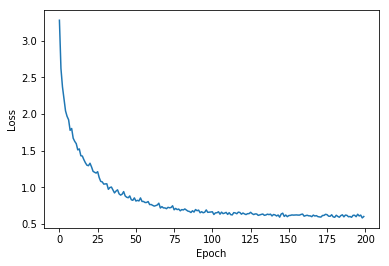

In [15]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(all_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
# Save the network
torch.save(rnn.state_dict(), save_model)

# Name Generating

In [17]:
# Now we can generate as many names as we want

print(sample("Dwarf", start="Dhu"))
print(sample("Human", start="Rod"))
print(sample("Elf", start="El"))

Dhurin
Rodreth (Steward)
Elrond


In [18]:
# We can see how different the names are even when they start the same
for category in categories:
    print("%s: %s" % (category, sample(category, start="Hal")))
print()
for category in categories:
    print("%s: %s" % (category, sample(category, start="Es")))

Human: Hallatan
Elf: Haldir (Lorien)
Dwarf: Halchar
Hobbit: Halfred Greenhand
Maiar: Halmac Horngor

Human: Estelmo
Elf: Esel
Dwarf: Eser:Deathshriek
Hobbit: Esmeralda Brandybuck
Maiar: Esmer (Gondor)


## If you're interested in RNNs, then take a look at the following pytorch tutorial, I created this notebook after completing it: [https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#Creating-the-Network](http://)
##  
